EV Birnbaum/Rubin - initial data prep DataFrame
* read in pickle
* split into chapters
* run several functions to chunk the text
* all in dataframes this time compared to lists in tex_prep_v02
* need to consider merging/fixing words that are split over a new line

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
import pickle

In [3]:
book_dict = {'The Elephant Vanishes': 'ev_birnbaum_rubin_v01', 
             'Norwegian Wood 1': 'nw_birnbaum_v01', 
             'Norwegian Wood 2': 'nw_rubin_v01',
             'Wild Sheep Chase': 'wsc_birnbaum_v01', 
             'Wind Up Bird Chronicle': 'wubc_all_rubin_v01', 
             'Sputnik Sweetheart': 'ss_gabriel_v01',
             'Kafka on the Shore': 'kots_gabriel_v01'}

In [4]:
books = pd.DataFrame.from_dict(book_dict, orient='index').reset_index()
books.columns = ['Title', 'Pickle']
books

,Title,Pickle
0,The Elephant Vanishes,ev_birnbaum_rubin_v01
1,Norwegian Wood 1,nw_birnbaum_v01
2,Norwegian Wood 2,nw_rubin_v01
3,Wild Sheep Chase,wsc_birnbaum_v01
4,Wind Up Bird Chronicle,wubc_all_rubin_v01
5,Sputnik Sweetheart,ss_gabriel_v01
6,Kafka on the Shore,kots_gabriel_v01


In [5]:
def load_pickle(filename):
    in_path = '../../../../Documents/murakami/pkl/' + filename + '.pkl'
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [6]:
books['full_text'] = books['Pickle'].apply(load_pickle)

In [7]:
books

,Title,Pickle,full_text
0,The Elephant Vanishes,ev_birnbaum_rubin_v01,I’M IN THE kitchen cooking spaghetti when the ...
1,Norwegian Wood 1,nw_birnbaum_v01,C H II P T E R 6 (rontinutd) The scene at dinn...
2,Norwegian Wood 2,nw_rubin_v01,[Haruki Murakami Norwegian Wood This book was ...
3,Wild Sheep Chase,wsc_birnbaum_v01,"[\n , \n \n \n , Contents \n Cover \n About th..."
4,Wind Up Bird Chronicle,wubc_all_rubin_v01,[1 \n Tuesday’s Wind-up Bird \n ♦ \n Six Finge...
5,Sputnik Sweetheart,ss_gabriel_v01,[Haruki Murakami None This book was produced i...
6,Kafka on the Shore,kots_gabriel_v01,[Kafka on the Shore \n Haruki Murakami \n \n \...


In [8]:
# books.iloc[0,2]

In [9]:
ev = books['full_text'].iloc[0]

In [11]:
# split the full text on triple line break to split into stories
# we have 14 stories
len(ev.split('\n\n\n'))

14

In [12]:
# split the book into stories on the phrase 'translated by' 
# then take whatever is after that up to a line break
trans_list = []
for story in ev.split('\n\n\n'):
    trans_list.append(story.split('translated by')[1].split('\n')[0])

In [13]:
trans_list

[' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin']

In [21]:
ch_texts = ev.split('\n\n\n')

In [22]:
ch_nos = [i+1 for i in range(len(ch_texts))]

In [23]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_nos, 'text': ch_texts})
chapters.head(10)

,number,title,text
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...
1,2,2,I’M STILL NOT sure I made the right choice whe...
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a..."
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ..."
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...
5,6,6,"\n“MOTHER DUMPED MY Father,” a friend of my wi..."
6,7,7,I MET HER at the wedding party of an acquainta...
7,8,8,"GREETINGS,\nThe winter cold diminishes with ea..."
8,9,9,IT WAS SUNDAY evening when the TV People showe...
9,10,10,WHEN DID I meet my first Chinese?\nJust like t...


In [24]:
# function to find indices of full stops in a text
def fs_indexer(x):
    return [i for i, char in enumerate(x) if char == "."]

In [25]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [26]:
chapters.dropna(inplace=True)
chapters.tail(30)

,number,title,text,fstop_indices
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7..."
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6..."
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4..."
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ..."
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10..."
5,6,6,"\n“MOTHER DUMPED MY Father,” a friend of my wi...","[102, 120, 210, 276, 412, 449, 606, 662, 730, ..."
6,7,7,I MET HER at the wedding party of an acquainta...,"[69, 95, 204, 357, 414, 461, 620, 680, 723, 86..."
7,8,8,"GREETINGS,\nThe winter cold diminishes with ea...","[121, 148, 191, 343, 664, 839, 859, 867, 963, ..."
8,9,9,IT WAS SUNDAY evening when the TV People showe...,"[50, 70, 103, 183, 228, 272, 302, 396, 454, 48..."
9,10,10,WHEN DID I meet my first Chinese?\nJust like t...,"[113, 166, 251, 314, 389, 477, 522, 601, 619, ..."


In [27]:
# function to find indices of full stops in a text
def split_indexer(text, n=1000):
    fstop_indices = fs_indexer(text)
    split_indices = []
    try:
        for j in range(n, len(text), n):
            i = 0
    # keep going through the indices while less than the 1000 step
            while fstop_indices[i] < j:
                i += 1
    # append list with the index of the full stop before the 1000 step
            split_indices.append(fstop_indices[i-1])
    except:
        split_indices = np.NaN


    return split_indices

In [28]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))

In [29]:
chapters.tail(20)

,number,title,text,fstop_indices,split_indices
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953..."
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6...","[962, 1872, 2949, 3966, 4960, 5996, 6970, 7941..."
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4...","[995, 1881, 2973, 3845, 4993, 5979, 6936, 7990..."
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ...","[932, 1944, 2993, 3893, 4937, 5947, 6878, 7849..."
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10...","[890, 1983, 2947, 3929, 4953, 5843, 6987, 7888..."
5,6,6,"\n“MOTHER DUMPED MY Father,” a friend of my wi...","[102, 120, 210, 276, 412, 449, 606, 662, 730, ...","[972, 1975, 2970, 3992, 4996, 5993, 6979, 7972..."
6,7,7,I MET HER at the wedding party of an acquainta...,"[69, 95, 204, 357, 414, 461, 620, 680, 723, 86...","[860, 1976, 2881, 3972, 4923, 5954, 6996, 7979..."
7,8,8,"GREETINGS,\nThe winter cold diminishes with ea...","[121, 148, 191, 343, 664, 839, 859, 867, 963, ...","[963, 1940, 2989, 3839, 4982, 5912, 6988, 7934..."
8,9,9,IT WAS SUNDAY evening when the TV People showe...,"[50, 70, 103, 183, 228, 272, 302, 396, 454, 48...","[983, 1947, 2958, 3903, 4963, 5995, 6963, 7980..."
9,10,10,WHEN DID I meet my first Chinese?\nJust like t...,"[113, 166, 251, 314, 389, 477, 522, 601, 619, ...","[904, 1987, 2888, 3968, 4901, 5999, 6893, 7948..."


In [30]:
chapters.dropna(inplace=True)

In [31]:
# function to chunk a text
def text_chunker(text):
    split_indices = split_indexer(text)
    chunks = []
    for i, idx in enumerate(split_indices):
# if first split then start at index 0 and keep up to the full stop index (including the full stop)
        if i == 0:
            chunks.append(text[0:idx+1])
# else start from the end of the previous chunk after the full stop until the next
        else:
            chunks.append(text[split_indices[i-1]+2:idx+1])
    return chunks

In [32]:
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))

In [33]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",[I’M IN THE kitchen cooking spaghetti when the...
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6...","[962, 1872, 2949, 3966, 4960, 5996, 6970, 7941...",[I’M STILL NOT sure I made the right choice wh...
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4...","[995, 1881, 2973, 3845, 4993, 5979, 6936, 7990...","[SAY HEY, HOW’S tricks?\nThis morning, I paid ..."
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ...","[932, 1944, 2993, 3893, 4937, 5947, 6878, 7849...","[ONE BEAUTIFUL APRIL morning, on a narrow side..."
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10...","[890, 1983, 2947, 3929, 4953, 5843, 6987, 7888...",[1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST N...


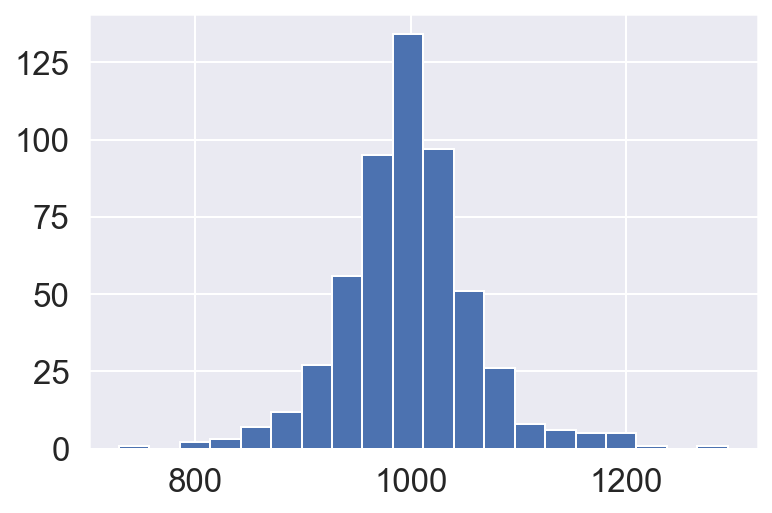

In [34]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [35]:
len(lengths)

537

In [36]:
chapters['translator'] = trans_list

In [37]:
chapters['book_title'] = 'The Elephant Vanishes'

In [38]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",[I’M IN THE kitchen cooking spaghetti when the...,Alfred Birnbaum,The Elephant Vanishes
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6...","[962, 1872, 2949, 3966, 4960, 5996, 6970, 7941...",[I’M STILL NOT sure I made the right choice wh...,Jay Rubin,The Elephant Vanishes
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4...","[995, 1881, 2973, 3845, 4993, 5979, 6936, 7990...","[SAY HEY, HOW’S tricks?\nThis morning, I paid ...",Alfred Birnbaum,The Elephant Vanishes
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ...","[932, 1944, 2993, 3893, 4937, 5947, 6878, 7849...","[ONE BEAUTIFUL APRIL morning, on a narrow side...",Jay Rubin,The Elephant Vanishes
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10...","[890, 1983, 2947, 3929, 4953, 5843, 6987, 7888...",[1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST N...,Alfred Birnbaum,The Elephant Vanishes


In [40]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'ev_birnbaum_rubin_v01'
out_full_path = out_path + out_name + '.pkl'

In [41]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    read_ev = pickle.load(fp)

In [42]:
read_ev

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",[I’M IN THE kitchen cooking spaghetti when the...,Alfred Birnbaum,The Elephant Vanishes
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6...","[962, 1872, 2949, 3966, 4960, 5996, 6970, 7941...",[I’M STILL NOT sure I made the right choice wh...,Jay Rubin,The Elephant Vanishes
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4...","[995, 1881, 2973, 3845, 4993, 5979, 6936, 7990...","[SAY HEY, HOW’S tricks?\nThis morning, I paid ...",Alfred Birnbaum,The Elephant Vanishes
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ...","[932, 1944, 2993, 3893, 4937, 5947, 6878, 7849...","[ONE BEAUTIFUL APRIL morning, on a narrow side...",Jay Rubin,The Elephant Vanishes
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10...","[890, 1983, 2947, 3929, 4953, 5843, 6987, 7888...",[1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST N...,Alfred Birnbaum,The Elephant Vanishes
5,6,6,"\n“MOTHER DUMPED MY Father,” a friend of my wi...","[102, 120, 210, 276, 412, 449, 606, 662, 730, ...","[972, 1975, 2970, 3992, 4996, 5993, 6979, 7972...","[\n“MOTHER DUMPED MY Father,” a friend of my w...",Alfred Birnbaum,The Elephant Vanishes
6,7,7,I MET HER at the wedding party of an acquainta...,"[69, 95, 204, 357, 414, 461, 620, 680, 723, 86...","[860, 1976, 2881, 3972, 4923, 5954, 6996, 7979...",[I MET HER at the wedding party of an acquaint...,Alfred Birnbaum,The Elephant Vanishes
7,8,8,"GREETINGS,\nThe winter cold diminishes with ea...","[121, 148, 191, 343, 664, 839, 859, 867, 963, ...","[963, 1940, 2989, 3839, 4982, 5912, 6988, 7934...","[GREETINGS,\nThe winter cold diminishes with e...",Jay Rubin,The Elephant Vanishes
8,9,9,IT WAS SUNDAY evening when the TV People showe...,"[50, 70, 103, 183, 228, 272, 302, 396, 454, 48...","[983, 1947, 2958, 3903, 4963, 5995, 6963, 7980...",[IT WAS SUNDAY evening when the TV People show...,Alfred Birnbaum,The Elephant Vanishes
9,10,10,WHEN DID I meet my first Chinese?\nJust like t...,"[113, 166, 251, 314, 389, 477, 522, 601, 619, ...","[904, 1987, 2888, 3968, 4901, 5999, 6893, 7948...",[WHEN DID I meet my first Chinese?\nJust like ...,Alfred Birnbaum,The Elephant Vanishes


In [39]:
chapters.explode('chunks')

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I’M IN THE kitchen cooking spaghetti when the ...,Alfred Birnbaum,The Elephant Vanishes
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",And I pride myself on a near-perfect ear for v...,Alfred Birnbaum,The Elephant Vanishes
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","“I hardly had any breakfast, so I was getting ...",Alfred Birnbaum,The Elephant Vanishes
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I stare blankly at the receiver in my hand and...,Alfred Birnbaum,The Elephant Vanishes
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","What the hell, I tell myself, what do I care a...",Alfred Birnbaum,The Elephant Vanishes
...,...,...,...,...,...,...,...,...
13,14,14,WHEN THE ELEPHANT disappeared from our town’s ...,"[94, 147, 290, 439, 707, 772, 918, 939, 1007, ...","[939, 1844, 2999, 3977, 4821, 5996, 6948, 7770...",And if I had told them I was watching the elep...,Jay Rubin,The Elephant Vanishes
13,14,14,WHEN THE ELEPHANT disappeared from our town’s ...,"[94, 147, 290, 439, 707, 772, 918, 939, 1007, ...","[939, 1844, 2999, 3977, 4821, 5996, 6948, 7770...","As I watched, it became obvious to me that thi...",Jay Rubin,The Elephant Vanishes
13,14,14,WHEN THE ELEPHANT disappeared from our town’s ...,"[94, 147, 290, 439, 707, 772, 918, 939, 1007, ...","[939, 1844, 2999, 3977, 4821, 5996, 6948, 7770...","“So, then, you believe that the elephant kept ...",Jay Rubin,The Elephant Vanishes
13,14,14,WHEN THE ELEPHANT disappeared from our town’s ...,"[94, 147, 290, 439, 707, 772, 918, 939, 1007, ...","[939, 1844, 2999, 3977, 4821, 5996, 6948, 7770...",I never should have told her about the elephan...,Jay Rubin,The Elephant Vanishes
